In [1]:
#Importing all the necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
from scipy.stats import linregress

In [2]:
# Downloading the stock data for a specific period and saving it into a dataframe
df_ma = yf.download('MA', start ='2025-01-28', end = '2025-01-29', interval="1m")
df_v = yf.download('V', start ='2025-01-28', end = '2025-01-29', interval="1m")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
df_ma

Price,Close,High,Low,Open,Volume
Ticker,MA,MA,MA,MA,MA
Datetime,,,,,
2025-01-28 14:30:00+00:00,545.265015,546.934998,544.080017,546.539978,64962
2025-01-28 14:31:00+00:00,543.500000,545.265015,543.500000,545.265015,4170
2025-01-28 14:32:00+00:00,544.715027,545.390015,542.659973,542.659973,11024
2025-01-28 14:33:00+00:00,546.190002,546.190002,544.715027,544.715027,7452
2025-01-28 14:34:00+00:00,545.200012,546.190002,545.200012,546.190002,4333
...,...,...,...,...,...
2025-01-28 20:55:00+00:00,548.099976,548.400024,548.075012,548.400024,13375
2025-01-28 20:56:00+00:00,548.130005,548.450012,548.075012,548.190002,23722


In [7]:
# Getting rid of the double heading to be able to manipulate the data properly
df_ma.columns =['Close', 'High', 'Low', 'Open', 'Volume']
df_v.columns =['Close', 'High', 'Low', 'Open', 'Volume']

In [9]:
# Combine the two dataframes based on the Datetime index
combined_df = pd.concat([df_ma[['Open', 'Close']], df_v[['Open', 'Close']]], axis=1, keys=['MA', 'V'])
# Forward fill missing values to handle different rows
combined_df = combined_df.ffill()
# Rename columns for clarity
combined_df.columns = ['MA_Open', 'MA_Close', 'V_Open', 'V_Close']
#Display new database
combined_df

,MA_Open,MA_Close,V_Open,V_Close
Datetime,,,,
2025-01-28 14:30:00+00:00,546.539978,545.265015,334.670013,333.679993
2025-01-28 14:31:00+00:00,545.265015,543.500000,333.309998,333.500000
2025-01-28 14:32:00+00:00,542.659973,544.715027,333.445007,333.399994
2025-01-28 14:33:00+00:00,544.715027,546.190002,333.589996,334.204987
2025-01-28 14:34:00+00:00,546.190002,545.200012,334.019989,333.670013
...,...,...,...,...
2025-01-28 20:55:00+00:00,548.400024,548.099976,335.019989,334.820007
2025-01-28 20:56:00+00:00,548.190002,548.130005,334.845001,334.910004
2025-01-28 20:57:00+00:00,548.219971,547.645020,334.920013,334.829987


In [11]:
#Create two separate df-s with only the close values to be able to calculate the cointegration
p1 = combined_df['MA_Close']
p2 = combined_df['V_Close']

In [13]:
# Calculate the cointegration using the Engle_Granger cointegration test. If it is lower than 5% than it means the pairs are cointegrated.
score, p_value, _ = coint(p1,p2)
p_value

0.040548054896534604

In [15]:
# Calculating the returns of each row
S1_0 = combined_df['MA_Open'][0]
S2_0 = combined_df['V_Open'][0]
r1=np.log(combined_df['MA_Close']/combined_df['MA_Close'].shift(1))
r2=np.log(combined_df['V_Close']/combined_df['V_Close'].shift(1))

/var/folders/xc/tw7x6_8n0z30jr8_7fy3crgc0000gn/T/ipykernel_45655/998536090.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S1_0 = combined_df['MA_Open'][0]
/var/folders/xc/tw7x6_8n0z30jr8_7fy3crgc0000gn/T/ipykernel_45655/998536090.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S2_0 = combined_df['V_Open'][0]


In [17]:
# Calculating historical expected return and standard deviation
mu_1 = r1.mean()*389
mu_2 = r2.mean()*389
sigma_1 = r1.std()*np.sqrt(389)
sigma_2 = r2.std()*np.sqrt(389)
z_0 = 0

In [21]:
print(mu_1)
print(mu_2)
print(sigma_1)
print(sigma_2)

0.004027852288150454
0.00264058858957141
0.011530142537200656
0.010535581614330861


In [23]:
# Using a linear regression package to estimate beta
result=linregress(np.log(combined_df['MA_Close']),np.log(combined_df['V_Close']))
beta=result.slope

In [25]:
beta

0.9027876452122505

In [27]:
gamma = 0.4
delta=1
rho=r1.corr(r2)
T=1
M=len(combined_df['MA_Close'])

In [29]:
rho

0.5916542078379359

In [31]:
dt = T/M
S1 = np.zeros((M + 1, 1))
S2 = np.zeros((M + 1, 1))
z =  np.zeros((M + 1, 1))
a =  np.zeros((M + 1, 1))
b =  np.zeros((M + 1, 1))
c =  np.zeros((M + 1, 1))
Pi_1 = np.zeros((M + 1, 1))
Pi_2 = np.zeros((M + 1, 1))
tt = np.linspace(0, 1, M + 1)
z[0] = z_0
S1[0] = S1_0
S2[0] = S2_0
sigma_beta = np.sqrt(sigma_1 ** 2 + beta ** 2 * sigma_2 ** 2 + 2 * beta * sigma_1 * sigma_2 * rho)
eta = (-1/delta) * (mu_1 - sigma_1 ** 2/2 + beta*(mu_2 - sigma_2 ** 2/2))
rn = np.random.standard_normal(z.shape)
rn1 = np.random.standard_normal(S1.shape) 
rn2 = np.random.standard_normal(S2.shape) 
for t in range(1, M + 1):
    z[t] = z[t-1]* (1 - delta * (eta - z[t-1])) * dt + sigma_beta * np.sqrt(dt)*((sigma_1 + beta * sigma_2 * rho)/ sigma_beta * rn1[t] + beta * (sigma_2 * np.sqrt(1-rho ** 2)/sigma_beta) * rn1[t]);
    S1[t] = combined_df['MA_Close'][t-1]
    S2[t] = combined_df['V_Close'][t-1]

/var/folders/xc/tw7x6_8n0z30jr8_7fy3crgc0000gn/T/ipykernel_45655/1055842525.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S1[t] = combined_df['MA_Close'][t-1]
/var/folders/xc/tw7x6_8n0z30jr8_7fy3crgc0000gn/T/ipykernel_45655/1055842525.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S2[t] = combined_df['V_Close'][t-1]


Text(0.5, 1.0, 'z')

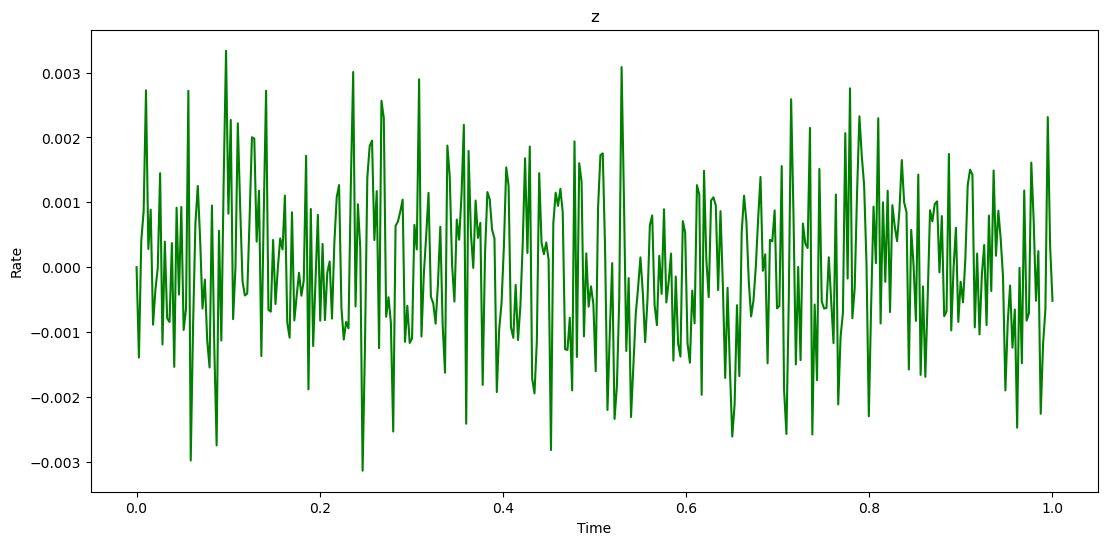

In [33]:
plt.figure(figsize=(13, 6))
plt.plot(tt, z, 'g', lw=1.5)
plt.xlabel('Time')
plt.ylabel('Rate')
plt.title('z')

In [35]:
for t in range(1, M + 1):
    a[t] = 0.5 * (T - t * dt)/((1-rho ** 2) * sigma_1 ** 2)
    b[t] = - 0.25 * (T - t * dt) ** 2 * (sigma_1 ** 2 + beta * sigma_2 ** 2)/((1 - rho ** 2) * sigma_1 ** 2) - rho * mu_2 * (T - t * dt)/((1 - rho **2) * sigma_1 * sigma_2)
    c[t] = 0.5 * mu_2 ** 2 * (T - t * dt)/((1 - rho ** 2) * sigma_2 ** 2) + 0.25 * (T - t * dt) ** 2 * (sigma_1 ** 2 + beta * sigma_2 ** 2 + 2 * sigma_1 * sigma_2 * beta *rho) * delta ** 2/((1 - rho ** 2) * sigma_1 ** 2) + 0.25 * (T - t * dt) ** 2 * mu_2 * delta * rho * (sigma_1 ** 2 + beta * sigma_2 ** 2) + 1/24 * (T - t * dt) ** 3 * (sigma_1 ** 2 + beta * sigma_2 ** 2) ** 2 * delta ** 2/((1 - rho ** 2) * sigma_1 ** 2)
    Pi_1[t] = (1 / S1[t]) * ((mu_1 + delta * z[t])/(gamma * (1 - rho ** 2) * sigma_1 ** 2) + delta/gamma * (-2 * a[t] * (mu_1 + delta * z[t])-b[t]) - rho * mu_2/(gamma * (1 - rho ** 2) * sigma_1 * sigma_2))
    Pi_2[t] = (1 / S2[t]) * (mu_2 / (gamma * (1 - rho ** 2) * sigma_2 ** 2) + delta * beta / gamma * (- 2 * a[t] * (mu_1 + delta * z[t]) - b[t]) - rho * (mu_1 + delta * z[t]) / (gamma * (1 - rho ** 2) * sigma_1 * sigma_2))

In [37]:
Pi_1[-1]

array([0.09498527])

In [39]:
Pi_2[-1]

array([0.07712452])

Text(0.5, 1.0, 'Weights')

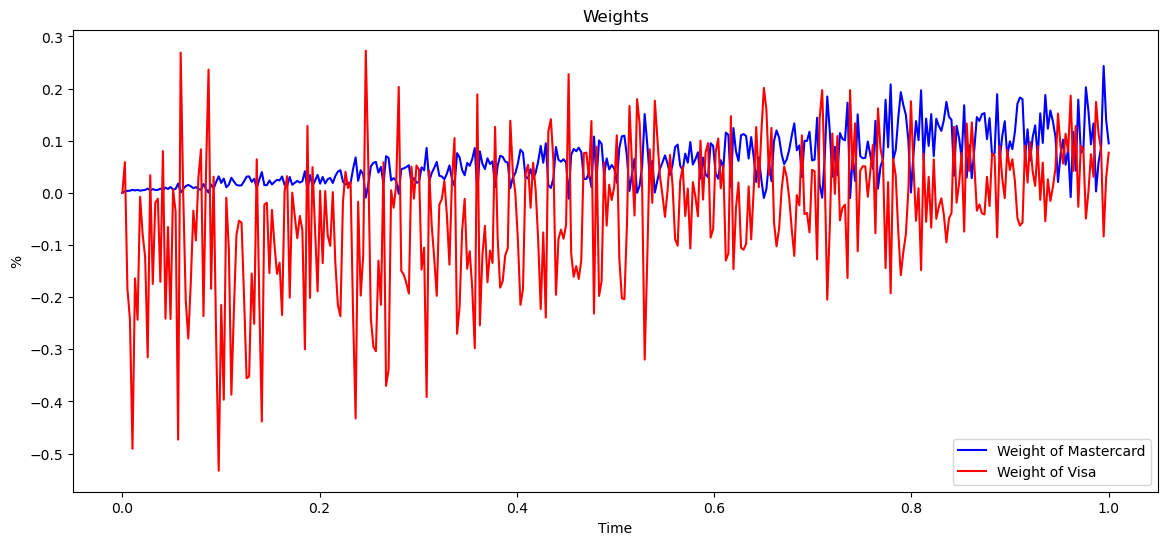

In [41]:
plt.figure(figsize=(14, 6))
plt.plot(tt, Pi_1, 'b', lw=1.5, label='Weight of Mastercard')
plt.plot(tt, Pi_2, 'r', lw=1.5, label='Weight of Visa')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('%')
plt.title('Weights')

Text(0.5, 1.0, 'Cash')

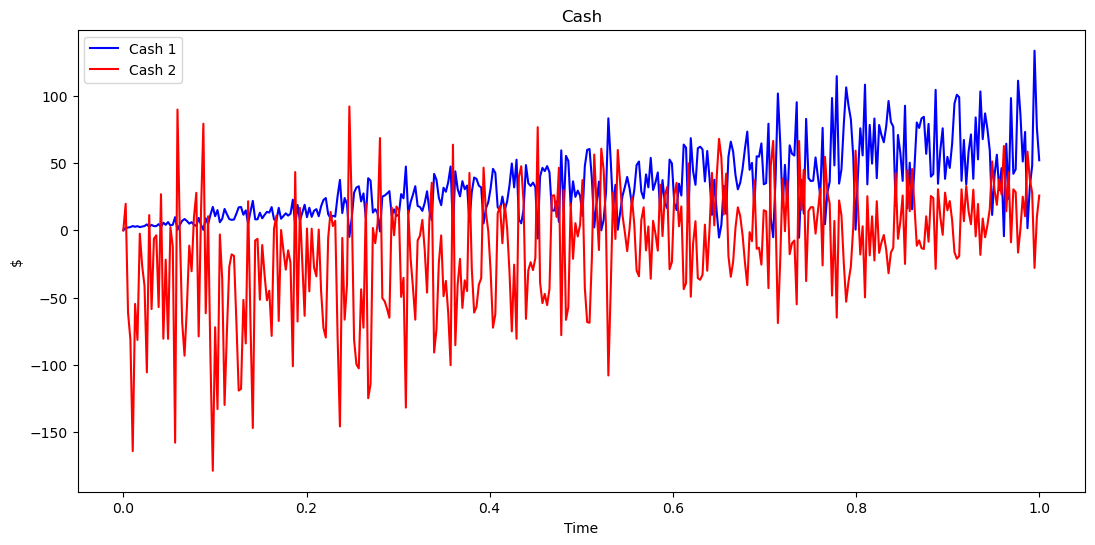

In [43]:
plt.figure(figsize=(13, 6))
plt.plot(tt, Pi_1 * S1, 'b', lw=1.5, label='Cash 1')
plt.plot(tt, Pi_2 * S2, 'r', lw=1.5, label='Cash 2')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('$')
plt.title('Cash')

In [45]:
wealth = abs(Pi_1*S1)+abs(Pi_2*S2)

Text(0.5, 1.0, 'Wealth')

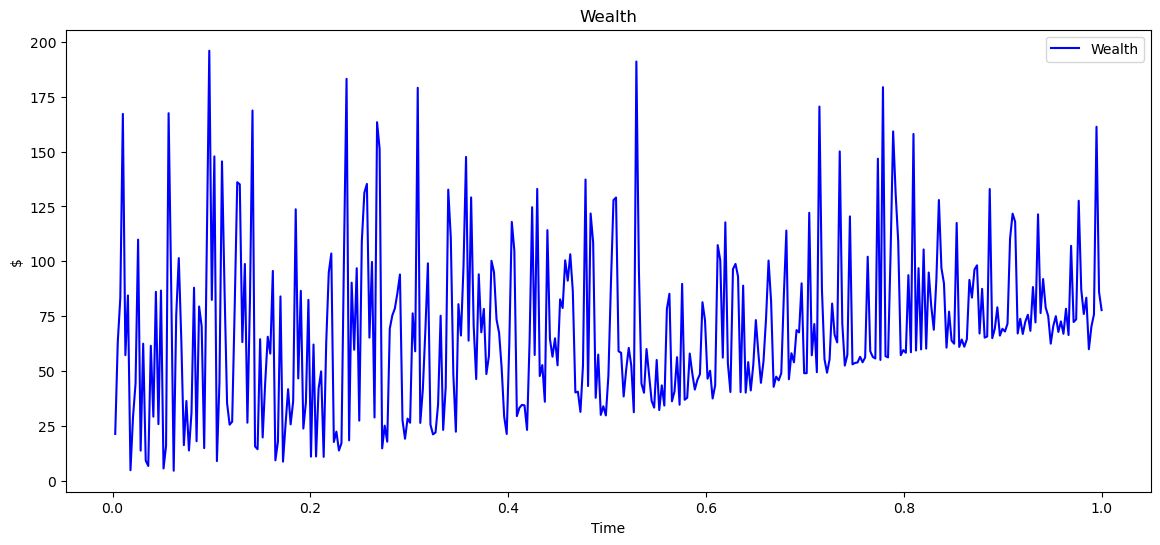

In [47]:
plt.figure(figsize=(14, 6))
plt.plot(tt[1:], wealth[1:], 'b', lw=1.5, label='Wealth')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('$')
plt.title('Wealth')

Text(0.5, 1.0, 'Comparison')

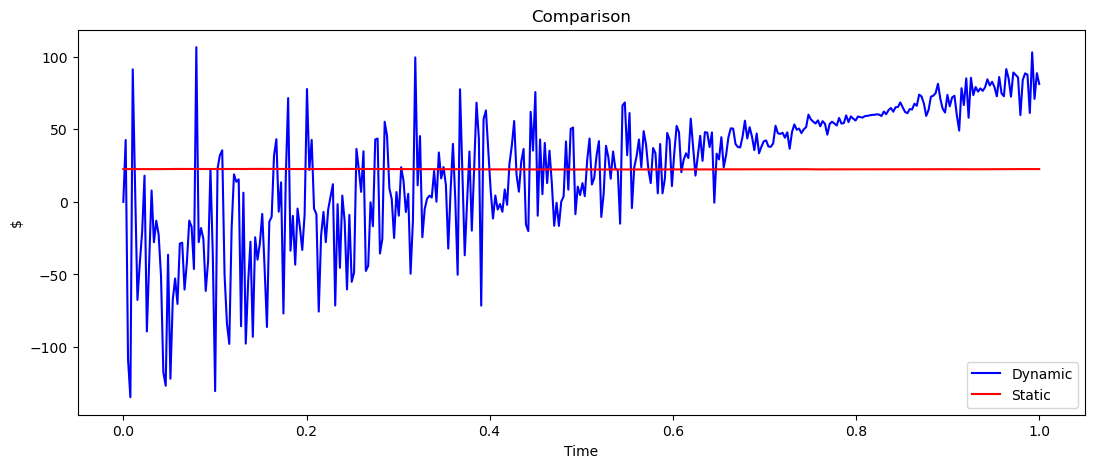

In [81]:
plt.figure(figsize=(13, 5))
plt.plot(tt, Pi_1 * S1 + Pi_2 * S2, 'b', lw=1.5, label='Dynamic')
plt.plot(tt, Pi_1.mean() * S1 + Pi_2.mean() * S2, 'r', lw=1.5, label='Static')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('$')
plt.title('Comparison')

In [51]:
# Simulating the trading strategy

In [53]:
combined_df.MA_Open.iloc[0]

546.5399780273438

In [55]:
# The figures are based on the estimates or the actual data of Mastercard and Visa calculated above.
S1_0 = combined_df.MA_Open.iloc[0]
S2_0 = combined_df.V_Open.iloc[0]
mu_1 = r1.mean()*389
mu_2 = r2.mean()*389
sigma_1 = r1.std()*np.sqrt(389)
sigma_2 = r2.std()*np.sqrt(389)
z_0 = 0
beta = 0.9027876452122505
gamma = 0.4
delta = 1
phi = 0.01
rho = r1.corr(r2)
T = 1
M = 389

In [57]:
dt = T/M
S1 = np.zeros((M + 1, 1))
S2 = np.zeros((M + 1, 1))
z =  np.zeros((M + 1, 1))
a =  np.zeros((M + 1, 1))
b =  np.zeros((M + 1, 1))
c =  np.zeros((M + 1, 1))
Pi_1 = np.zeros((M + 1, 1))
Pi_2 = np.zeros((M + 1, 1))

In [59]:
tt = np.linspace(0, 1, M + 1)
z[0] = z_0
S1[0] = S1_0
S2[0] = S2_0
sigma_beta = np.sqrt(sigma_1 ** 2 + beta ** 2 * sigma_2 ** 2 + 2 * beta * sigma_1 * sigma_2 * rho)
eta = (-1/delta) * (mu_1 - sigma_1 ** 2/2 + beta*(mu_2 - sigma_2 ** 2/2))
rn = np.random.standard_normal(z.shape)
rn1 = np.random.standard_normal(S1.shape) 
rn2 = np.random.standard_normal(S2.shape) 
for t in range(1, M + 1):
    z[t] = z[t-1]* (1 - delta * (eta - z[t-1])) * dt + sigma_beta * np.sqrt(dt)*((sigma_1 + beta * sigma_2 * rho)/ sigma_beta * rn1[t] + beta * (sigma_2 * np.sqrt(1-rho ** 2)/sigma_beta) * rn1[t]);
    S1[t] = S1[t-1] * np.exp((mu_1 + delta * z[t] - sigma_1 ** 2 / 2) * dt + sigma_1 * np.sqrt(dt) * rn1[t])
    S2[t] = S2[t-1] * np.exp((mu_2 - sigma_2 ** 2 / 2) * dt + sigma_2 * np.sqrt(dt) * (rho * rn1[t] + np.sqrt(1 - rho ** 2) * rn2[t]))

Text(0.5, 1.0, 'Stock Price')

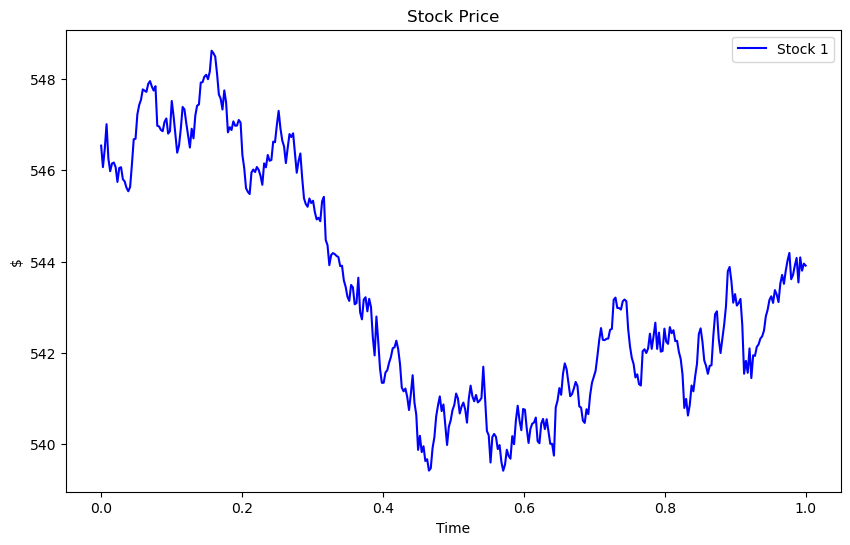

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(tt, S1, 'b', lw=1.5, label='Stock 1')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('$')
plt.title('Stock Price')

Text(0.5, 1.0, 'Z')

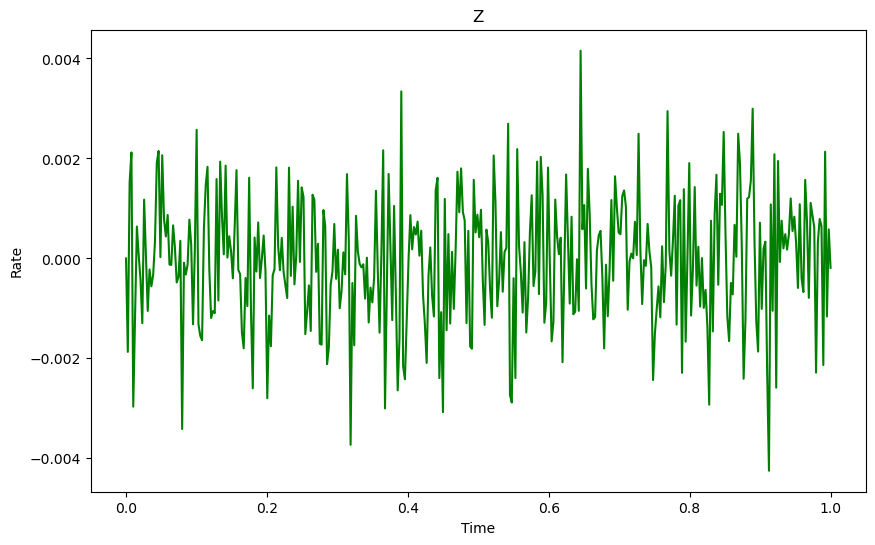

In [63]:
plt.figure(figsize=(10, 6))
plt.plot(tt, z, 'g', lw=1.5)
plt.xlabel('Time')
plt.ylabel('Rate')
plt.title('Z')

In [65]:
for t in range(1, M + 1):
    a[t] = 0.5 * (T - t * dt)/((1-rho ** 2) * sigma_1 ** 2)
    b[t] = - 0.25 * (T - t * dt) ** 2 * (sigma_1 ** 2 + beta * sigma_2 ** 2)/((1 - rho ** 2) * sigma_1 ** 2) - rho * mu_2 * (T - t * dt)/((1 - rho **2) * sigma_1 * sigma_2)
    c[t] = 0.5 * mu_2 ** 2 * (T - t * dt)/((1 - rho ** 2) * sigma_2 ** 2) + 0.25 * (T - t * dt) ** 2 * (sigma_1 ** 2 + beta * sigma_2 ** 2 + 2 * sigma_1 * sigma_2 * beta *rho) * delta ** 2/((1 - rho ** 2) * sigma_1 ** 2) + 0.25 * (T - t * dt) ** 2 * mu_2 * delta * rho * (sigma_1 ** 2 + beta * sigma_2 ** 2) + 1/24 * (T - t * dt) ** 3 * (sigma_1 ** 2 + beta * sigma_2 ** 2) ** 2 * delta ** 2/((1 - rho ** 2) * sigma_1 ** 2)
    Pi_1[t] = (1 / S1[t]) * ((mu_1 + delta * z[t])/(gamma * (1 - rho ** 2) * sigma_1 ** 2) + delta/gamma * (-2 * a[t] * (mu_1 + delta * z[t])-b[t]) - rho * mu_2/(gamma * (1 - rho ** 2) * sigma_1 * sigma_2))
    Pi_2[t] = (1 / S2[t]) * (mu_2 / (gamma * (1 - rho ** 2) * sigma_2 ** 2) + delta * beta / gamma * (- 2 * a[t] * (mu_1 + delta * z[t]) - b[t]) - rho * (mu_1 + delta * z[t]) / (gamma * (1 - rho ** 2) * sigma_1 * sigma_2))

Text(0.5, 1.0, 'Weights')

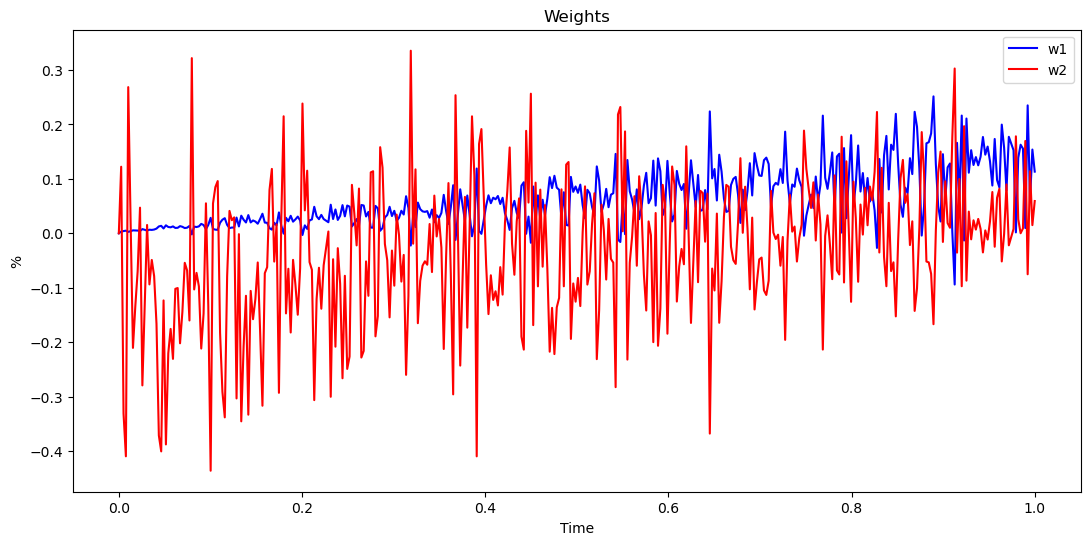

In [67]:
plt.figure(figsize=(13, 6))
plt.plot(tt, Pi_1, 'b', lw=1.5, label='w1')
plt.plot(tt, Pi_2, 'r', lw=1.5, label='w2')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('%')
plt.title('Weights')

Text(0.5, 1.0, 'Cash')

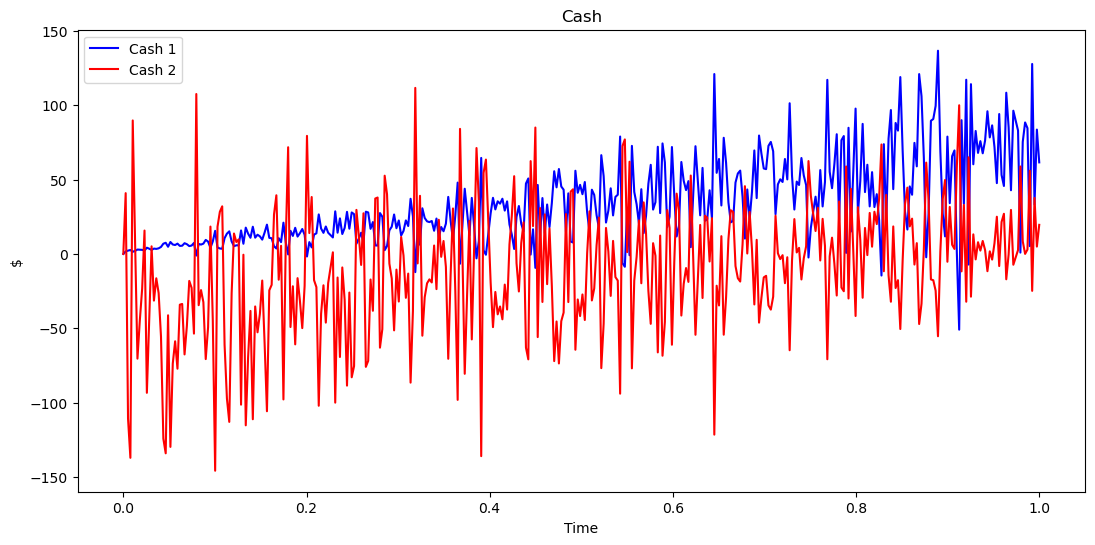

In [69]:
plt.figure(figsize=(13, 6))
plt.plot(tt, Pi_1 * S1, 'b', lw=1.5, label='Cash 1')
plt.plot(tt, Pi_2 * S2, 'r', lw=1.5, label='Cash 2')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('$')
plt.title('Cash')

In [71]:
Pi_1.mean()

0.06257557109194661

In [73]:
Pi_2.mean()

-0.034653830906942594

Text(0.5, 1.0, 'Comparison')

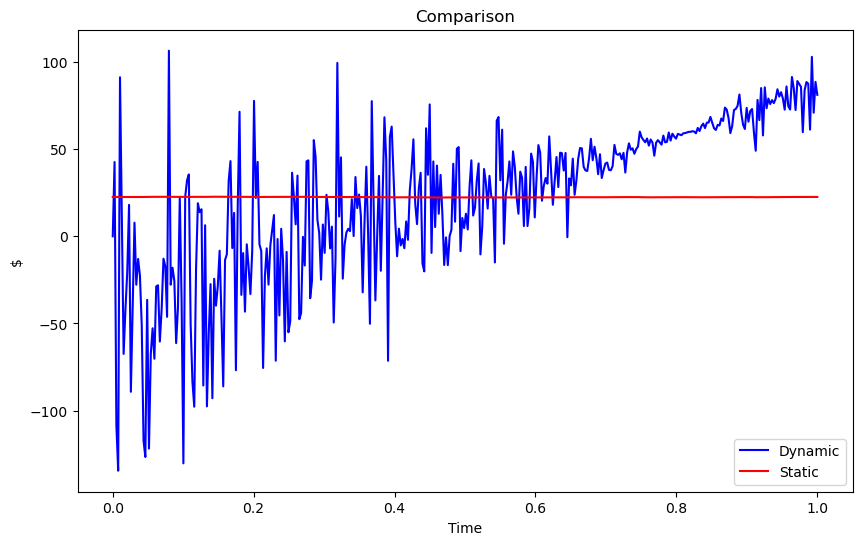

In [75]:
plt.figure(figsize=(10, 6))
plt.plot(tt, Pi_1 * S1 + Pi_2 * S2, 'b', lw=1.5, label='Dynamic')
plt.plot(tt, Pi_1.mean() * S1 + Pi_2.mean() * S2, 'r', lw=1.5, label='Static')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('$')
plt.title('Comparison')